# **Cats and Dogs Image Classification using Convolutional Neural Networks**

Over the past few years, image classification has become a pivotal application in the realm of computer vision. This notebook deals with the *Cat vs Dog Image classification* task, illustrating how to construct it utilizing Convolutional Neural Networks (CNNs).

Fundamentally, image classification entails employing machine learning algorithms to educate a computer to discern objects within a visual representation. When it comes to image classification tasks, CNNs are the go-to algorithms. These networks are specifically engineered to handle image data and possess the ability to detect intricate features within a picture that might evade human observation.

## Loading dependencies

In [1]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from random import sample
import numpy as np
import pandas as pd

import zipfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

# import shutil
# shutil.rmtree('/tmp/DogsCatsClassification', ignore_errors=True)

In [2]:
# Colab x Kaggle
from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/'1. Études/Projects Notebooks'/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


## Loading dataset

In [3]:
! kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:38<00:00, 23.7MB/s]
100% 812M/812M [00:38<00:00, 22.2MB/s]


In [4]:
# Processing the zip file of the Data
local_zip = "dogs-vs-cats.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp/DogsCatsClassification/")
zip_ref.close()

In [5]:
test_path = "/tmp/DogsCatsClassification/test1.zip"
train_path = "/tmp/DogsCatsClassification/train.zip"

files = "/kaggle/working/"

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

### Loading images in a dataframe

In [6]:
image_dir = "/kaggle/working/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.6983.jpg,cat
1,cat.9218.jpg,cat
2,dog.2039.jpg,dog
3,dog.6561.jpg,dog
4,cat.3291.jpg,cat


### Data Exploration

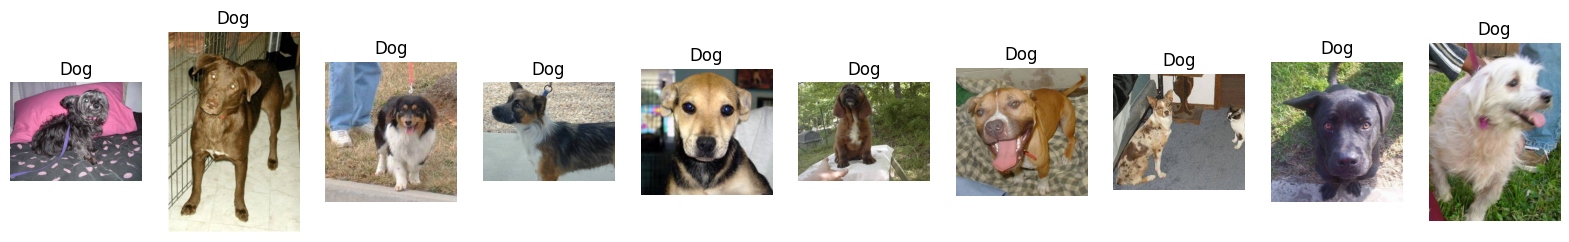

In [7]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)
    filename = image_dir + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

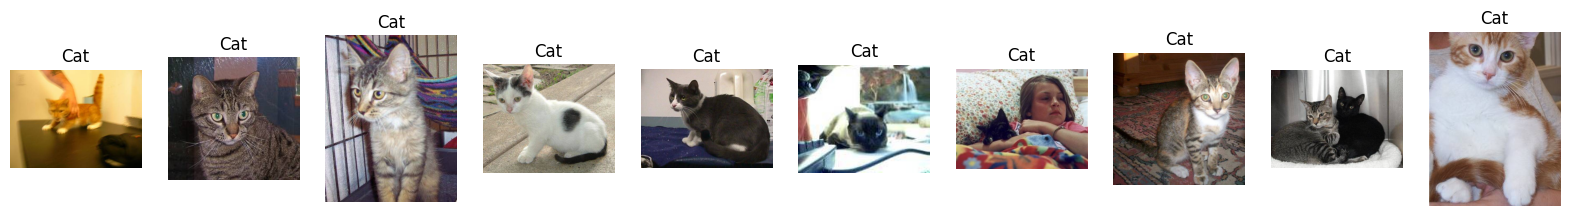

In [8]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = image_dir + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

### Train & Test splitting

In [9]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


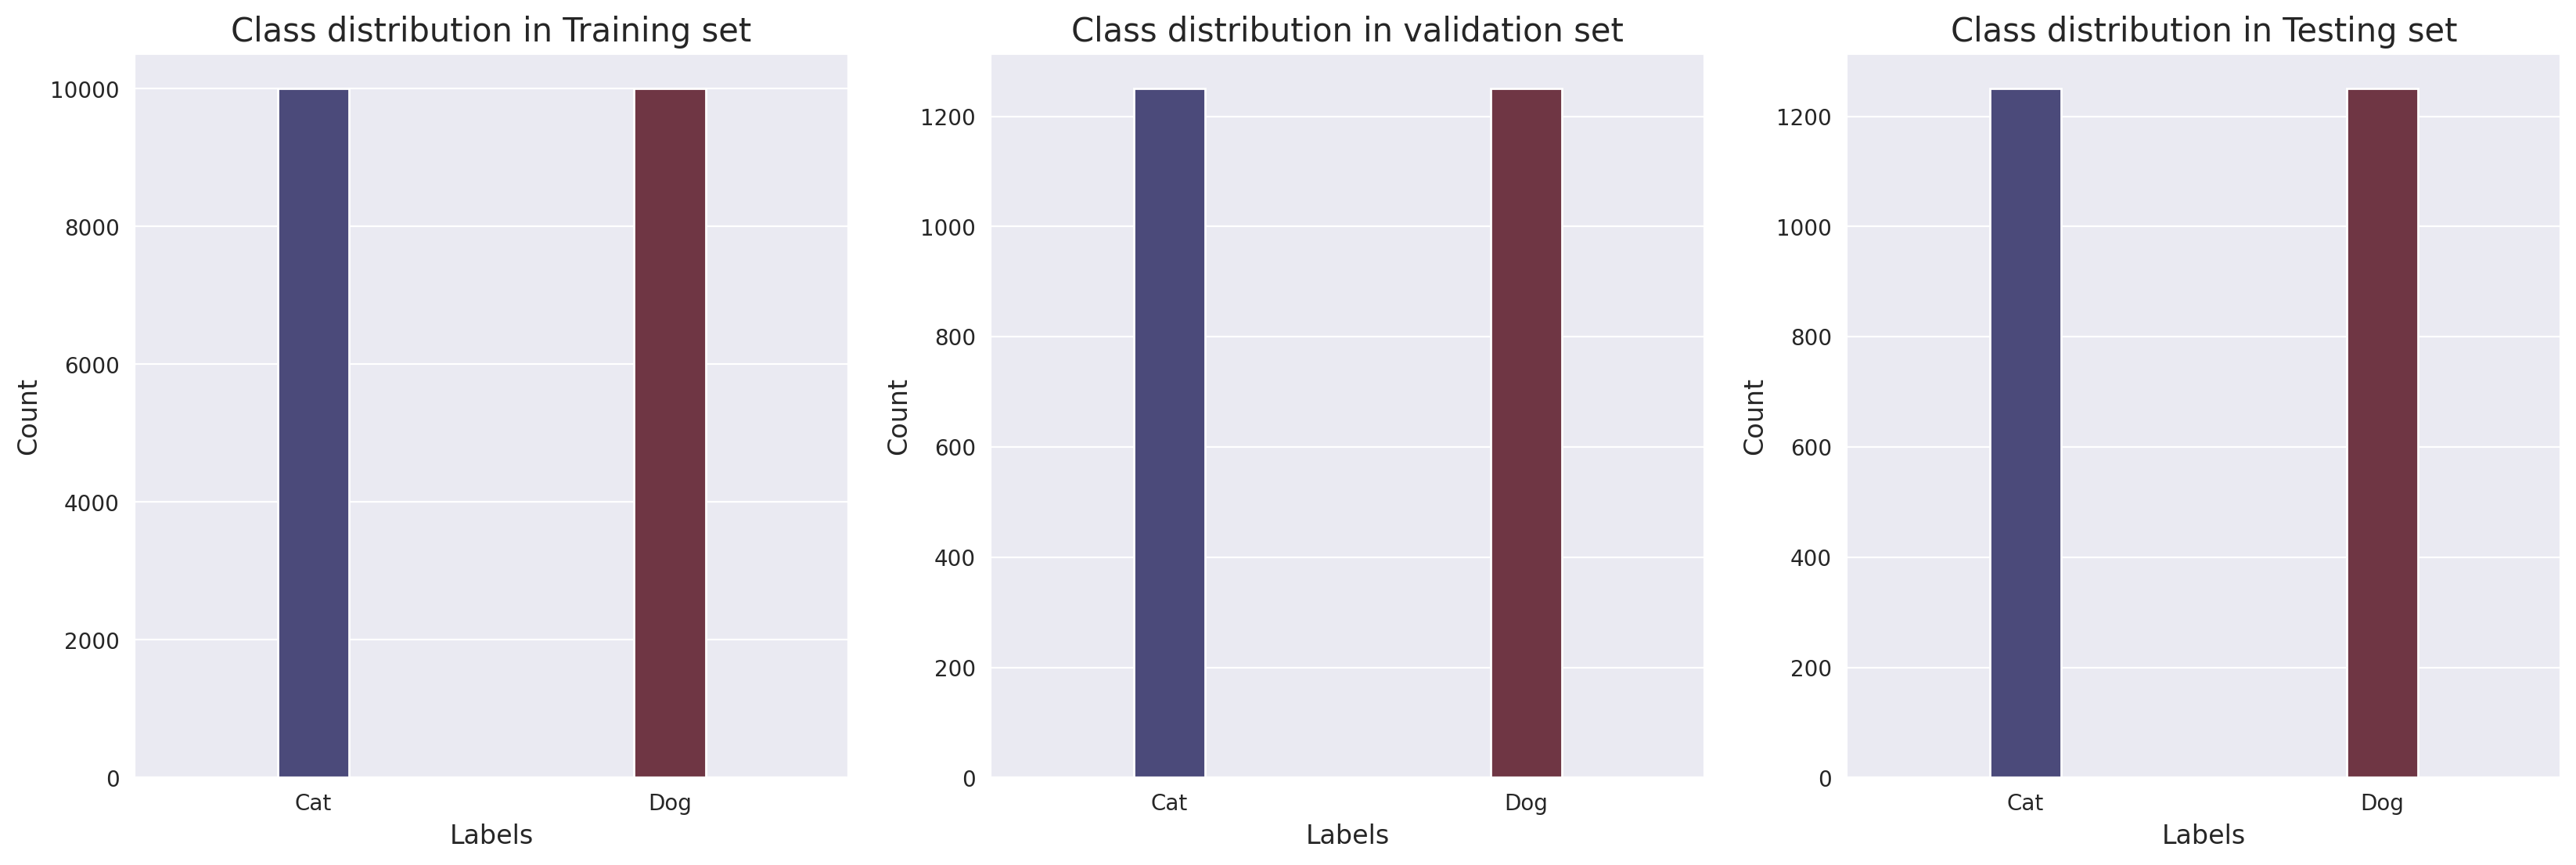

In [10]:
labels = ['Cat','Dog']

label1, count1 = np.unique(X_train.label, return_counts=True)
label2, count2 = np.unique(X_val.label, return_counts=True)
label3, count3 = np.unique(X_test.label, return_counts=True)

uni1 = pd.DataFrame(data=count1, index=labels, columns=['Count1'])
uni2 = pd.DataFrame(data=count2, index=labels, columns=['Count2'])
uni3 = pd.DataFrame(data=count3, index=labels, columns=['Count3'])


plt.figure(figsize=(20,6), dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,
            x=uni1.index,
            y='Count1',
            palette='icefire',
            hue=uni1.index,
            width=0.2).set_title('Class distribution in Training set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,
            x=uni2.index,
            y='Count2',
            hue=uni2.index,
            palette='icefire',
            width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,
            x=uni3.index,
            y='Count3',
            hue=uni3.index,
            palette='icefire',
            width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

## Data Preparation

In [11]:
image_size = 128
image_channel = 3
bat_size = 32

### Image Data Generator

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


## Convolutional Neural Network

### Model & Training

We will build CNN from scratch using `Tensorflow` and `Keras` API. Since it is a Binary Classfication problem, we will use sigmoid activation so that the output of the network will be a single scalar between 0 and 1, encodig the probability of the images.

In [14]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

In [15]:
# Summary of Neural Network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True, verbose=0)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

We are now going to train our model using the train iterator (`train_generator`) and use the val iterator (`val_generator`) as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).

The model will be fit for 30 epochs.

In [19]:
cat_dog_classifier = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 30,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/30
625/625 [==============================] - 138s 199ms/step - loss: 0.6493 - accuracy: 0.6698 - val_loss: 0.5867 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 123s 197ms/step - loss: 0.5013 - accuracy: 0.7577 - val_loss: 0.4961 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 125s 199ms/step - loss: 0.4254 - accuracy: 0.8038 - val_loss: 0.8728 - val_accuracy: 0.6492 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 122s 196ms/step - loss: 0.3737 - accuracy: 0.8290 - val_loss: 0.3416 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 123s 198ms/step - loss: 0.3330 - accuracy: 0.8532 - val_loss: 0.2970 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 123s 196ms/step - loss: 0.3146 - accuracy: 0.8626 - val_loss: 0.2988 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 7/30
625/625 [==========================

### Results

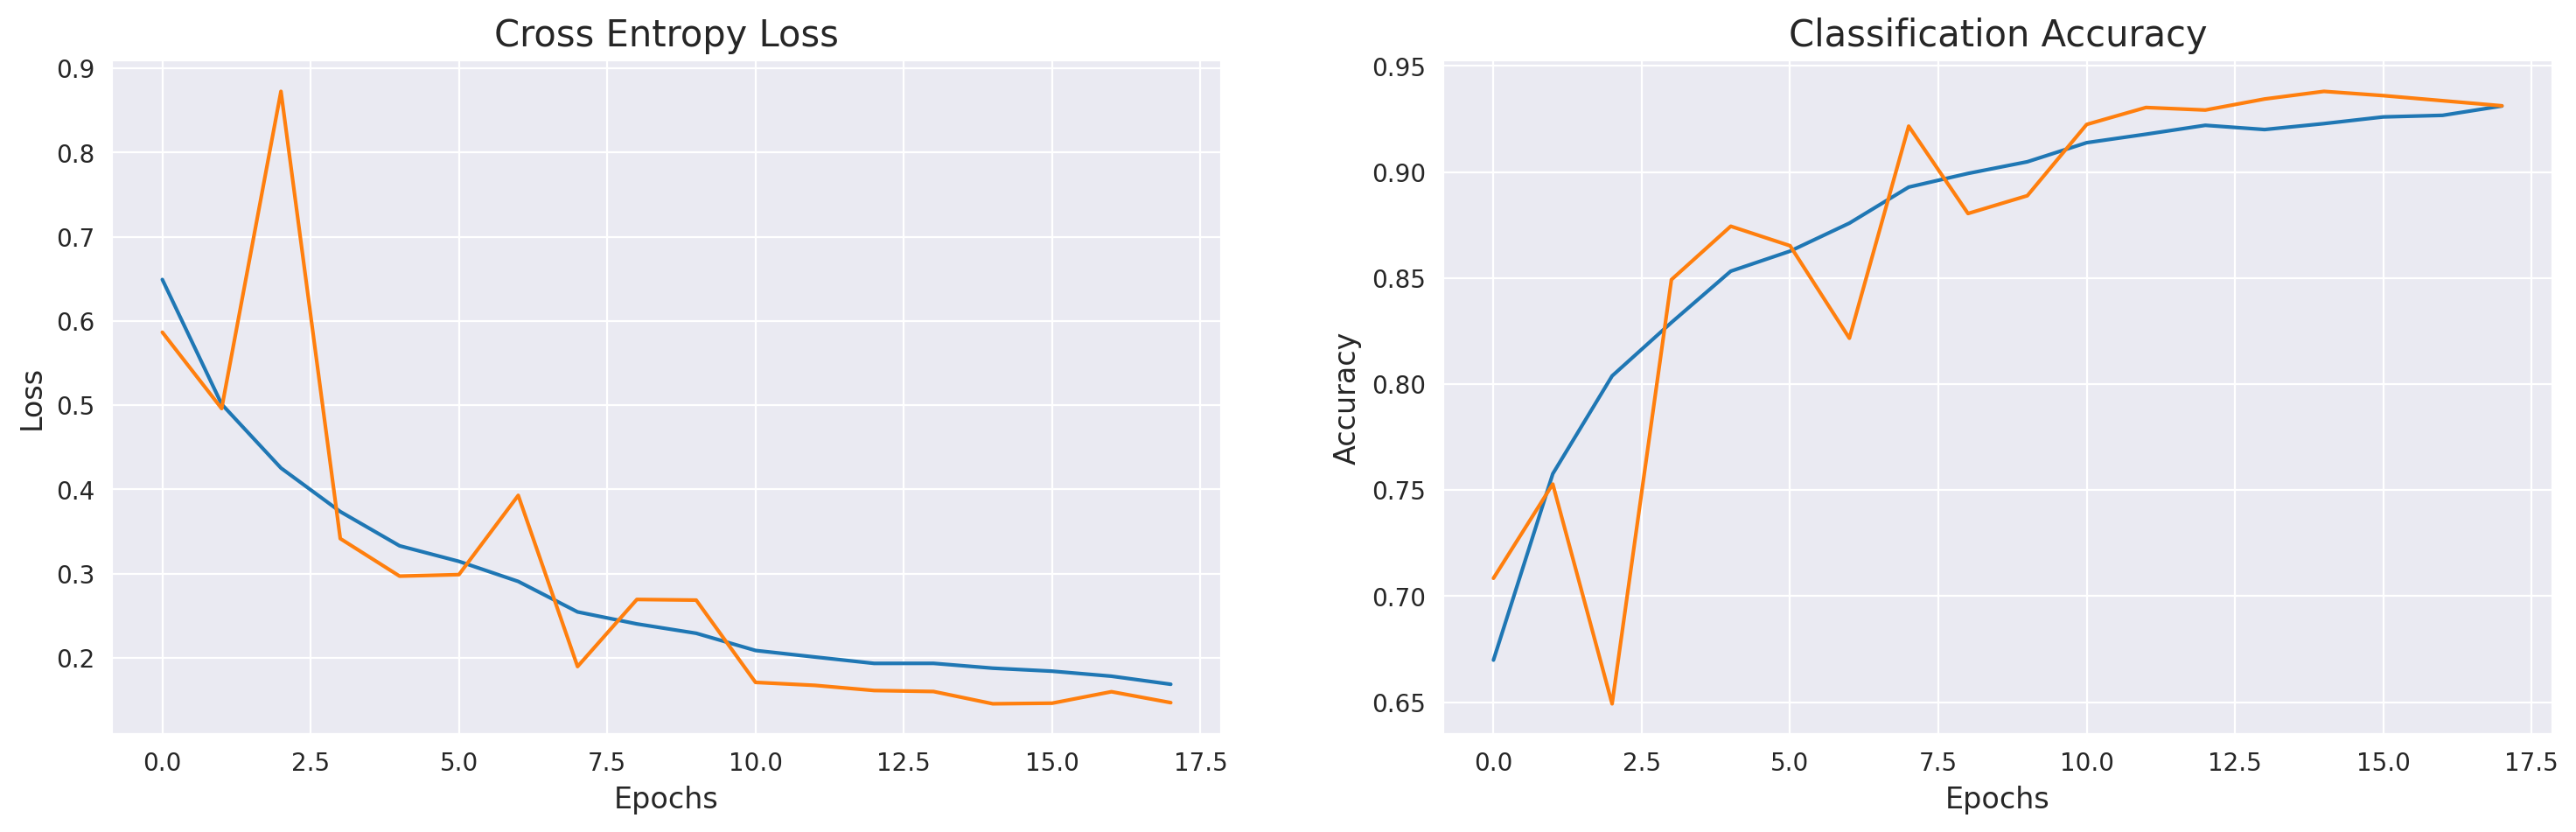

In [21]:
error = pd.DataFrame(cat_dog_classifier.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

### Evaluation

In [22]:
loss, acc = model.evaluate(train_generator,
                          batch_size = bat_size,
                          verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss, acc = model.evaluate(val_generator,
                          batch_size = bat_size,
                          verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 94.71499919891357
The Loss of the model for training data is: 0.13278500735759735
The accuracy of the model for validation data is: 93.80000233650208
The Loss of the model for validation data is: 0.14540447294712067


In [23]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Prediction

In [24]:
res = model.predict(test_generator,
                    batch_size = bat_size,
                    verbose = 0)

y_pred = np.argmax(res, axis = 1)

y_true = test_generator.labels

loss, acc = model.evaluate(test_generator,
                          batch_size = bat_size,
                          verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 93.87999773025513
The Loss of the model for testing data is: 0.15707442164421082


In [25]:
labels =['Cat','Dog']
print(classification_report(y_true,
                            y_pred,
                            target_names=labels))

              precision    recall  f1-score   support

         Cat       0.93      0.94      0.94      1250
         Dog       0.94      0.93      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



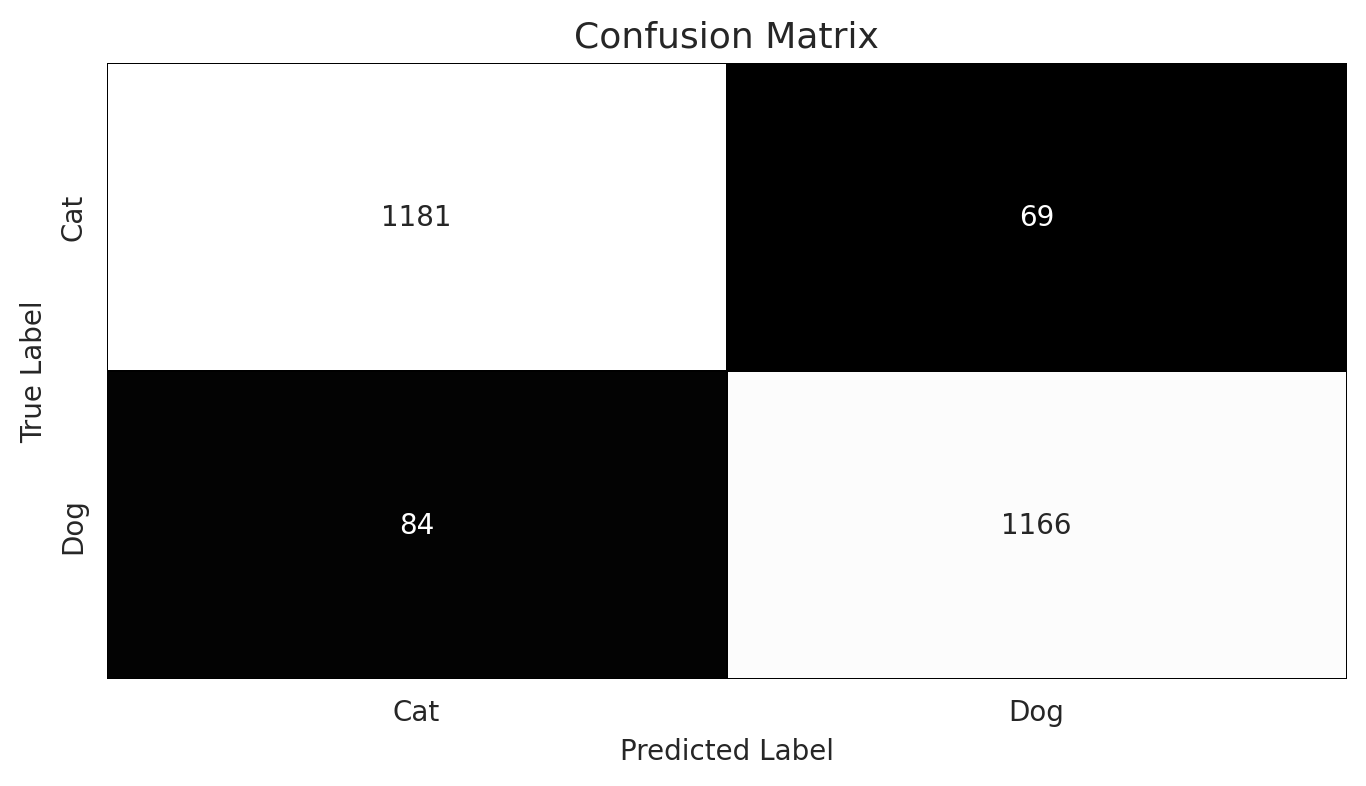

In [26]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx,
            annot=True,
            linewidths=0.1,
            cmap = "gist_yarg_r",
            linecolor="black",
            fmt='.0f',
            ax=ax,
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.show()

In [33]:
size =(128,128)
test_dir = "/kaggle/working/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create data genenerator for test data
test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     test_dir,
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = bat_size,
                                     target_size=size,
                                     shuffle = False)

# Test Prediction
test1_predict = model.predict(test1_idg,verbose = 0)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

Found 12500 validated image filenames belonging to 1 classes.


,filename,label
0,700.jpg,dog
1,5552.jpg,cat
2,1362.jpg,cat
3,10780.jpg,cat
4,3343.jpg,cat


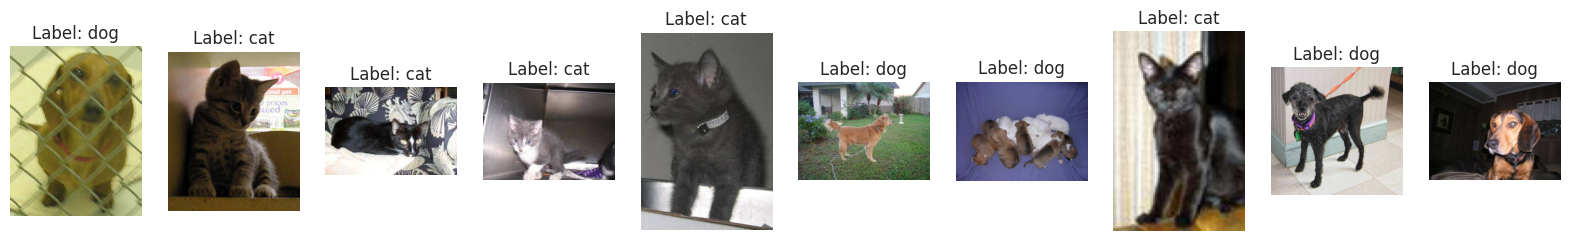

In [34]:
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for idx in range(10):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()